<a href="https://colab.research.google.com/github/peeyushsinghal/EVA/blob/main/S8-Assignment/EVA_S8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Libraries

In [1]:
# import torch
# from torchvision import datasets
# import torchvision.transforms as transforms
# %matplotlib inline
# import random # for random image index
# import torch.nn as nn # for network


# from tqdm import tqdm # for beautiful model training updates
# from model import Network

Seed and Cuda

In [2]:
# check for default device
import torch
def get_device():
  '''
  provide cuda (GPU) if available, else CPU
  '''
  cuda = torch.cuda.is_available()
  if cuda == True:
    return torch.device("cuda")
  else:
    return torch.device("cpu")

device = get_device()
print (f' device Status : {device}')
device

 device Status : cuda


device(type='cuda')

In [3]:
# # setting seed

import random
import numpy as np

def seed_all(seed_value : int):
  '''
  set seed for all, this is required for reproducibility and deterministic behaviour
  '''
  random.seed(seed_value)
  np.random.seed(seed_value)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
  else:
    torch.manual_seed(seed_value)
  


SEED = 42 # arbit seed, why 42 - because in hitch hikers guide to galaxy it is answer to everything
seed_all(SEED)

### 1. Loading Data



In [4]:
## downloading training data, using this to calculate mean and standard deviation 

# train_mean_std_dev = datasets.CIFAR10(
#     root = './',# directory where data needs to be stored
#     train = True, # get the training portion of the dataset
#     download = True, # downloads
#     transform = transforms.ToTensor()# converts to tesnor
#     )

In [5]:
# train_mean_std_dev.data.shape  ## looking at the shape of the data

In [6]:
# Getting Mean and Standard Deviation of CIFAR 10 dataset

from torchvision import datasets
import torchvision.transforms as transforms


def get_mean_std_dev(dataset_name):
  '''
  get mean and std deviation of dataset
  reference : https://stackoverflow.com/questions/66678052/how-to-calculate-the-mean-and-the-std-of-cifar10-data
  '''
  if dataset_name == "CIFAR10" :
    dataset = datasets.CIFAR10(
      root = './',# directory where data needs to be stored
      train = True, # get the training portion of the dataset
      download = True, # downloads
      transform = transforms.ToTensor()# converts to tensor
      )
    data = dataset.data / 255 # data is numpy array

    mean = data.mean(axis = (0,1,2)) 
    std = data.std(axis = (0,1,2))
    # print(f"Mean : {mean}   STD: {std}") #Mean : [0.491 0.482 0.446]   STD: [0.247 0.243 0.261]
    return tuple(mean), tuple(std)

  return (0,0,0),(0,0,0)

mean, std_dev = get_mean_std_dev("CIFAR10")
print(f"Mean : {mean}   STD: {std_dev}") #Mean : [0.491 0.482 0.446]   STD: [0.247 0.243 0.261]


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Mean : (0.4913996786152028, 0.4821584083946074, 0.4465309144454644)   STD: (0.24703223246328238, 0.2434851280000556, 0.26158784172796423)


In [7]:
!pip install -U albumentations

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

def apply_basic_transforms(mean,std_dev):
    train_transforms = A.Compose([
        A.Normalize(mean=mean, std=std_dev, always_apply=True),
        ToTensorV2(),
    ])

    test_transforms = A.Compose([
        A.Normalize(mean=mean, std=std_dev, always_apply=True),
        ToTensorV2(),
    ])

    return lambda img: train_transforms(image=np.array(img))["image"], lambda img: test_transforms(image=np.array(img))["image"]

def apply_transforms_resnet(mean,std_dev):
    train_transforms = A.Compose([

        A.Sequential(
                [
                    A.PadIfNeeded(min_height=40, min_width=40, always_apply=True),
                    A.RandomCrop(width=32, height=32, p=1),# Random Crop
                ],
                p=0.5,
            ),

        A.HorizontalFlip(p=0.2),
        A.Rotate(limit=5, p=0.2),# Rotate

        # A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.2),
        A.CoarseDropout(
            max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16, fill_value=tuple((x * 255.0 for x in mean)), p=0.2,
        ),# Cutout
        # A.ToGray(p=0.15),
        A.Normalize(mean=mean, std=std_dev, always_apply=True),
        ToTensorV2(),
    ])

    test_transforms = A.Compose([
        A.Normalize(mean=mean, std=std_dev, always_apply=True),
        ToTensorV2(),
    ])

    return lambda img: train_transforms(image=np.array(img))["image"], lambda img: test_transforms(image=np.array(img))["image"]


# train_transforms, test_transforms = apply_basic_transforms(mean,std_dev)
train_transforms, test_transforms = apply_transforms_resnet(mean,std_dev)
# print(train_transforms,"\n", test_transforms)

     |████████████████████████████████| 102 kB 5.3 MB/s 
     |████████████████████████████████| 47.6 MB 37 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


### Train and Test data

In [8]:
from torchvision import datasets

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


 **Labels**

In [9]:
labels = trainset.classes
labels

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

 **Train and Test set Dataloader**

In [10]:
batch_size = 128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

#### Visualizing Images


In [11]:
# images, labels = next(iter(trainloader))
# images.size()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

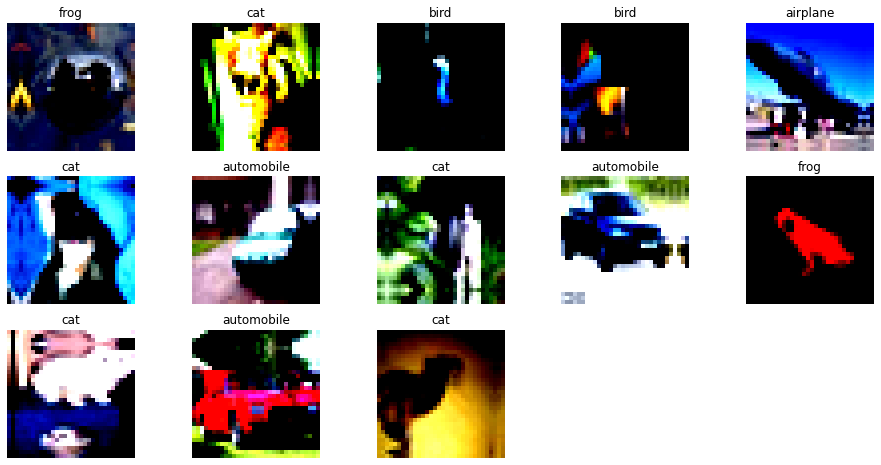

In [12]:
import matplotlib.pyplot as plt # for visualizing images


def show_batch(dataset_loader,label_names,num_images=10):
  '''
  shows a batch of images (default = 5)
  '''
  images, targets = next(iter(dataset_loader))
  plt.figure(figsize=(16, 8))
  for i in range(num_images):
    ax = plt.subplot(int(num_images//5)+1, 5, i + 1)
    ax.imshow(images[i].permute(1, 2, 0))
    plt.title(label_names[targets[i]])
    plt.axis("off")


show_batch(trainloader,labels,num_images=13)

### 2. Network
Defining CNN

In [13]:
'''
ResNet in PyTorch.
This is inspired by https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
  '''
  ResNet18 Model
  '''
  return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
  '''
  ResNet34 Model
  '''
  return ResNet(BasicBlock, [3, 4, 6, 3])


In [14]:
model = ResNet18().to(device)

from torchsummary import summary


def model_summary(model, input_size):
    """
    Summary of the model.
    """
    summary(model, input_size=input_size)
model_summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

#### Model Params
Checking the model summary and number of parameters


### 3. Training and Testing

*   includes test and train functions
*   includes loop function, where test can happen after each epoch is trained

In [15]:
import torch.optim as optim # for optimizer
import torch.nn as nn # for network, criterion
import torch.nn.functional as F 


criterion = nn.CrossEntropyLoss()

# epochs = 40
epochs = 2
lr = 0.001

# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [16]:

def trainer(model,device, trainloader, testloader, optimizer,epochs,criterion):
  train_losses = [] # to capture train losses over training epochs
  train_accuracy = [] # to capture train accuracy over training epochs
  test_losses = [] # to capture test losses 
  test_accuracy = [] # to capture test accuracy 
  for epoch in range(epochs):
    print("EPOCH:", epoch+1)
    train(model, device, trainloader, optimizer, epoch,criterion,train_accuracy,train_losses ) # Training Function
    test(model, device, testloader,criterion,test_accuracy,test_losses)   # Test Function

  return train_accuracy, train_losses, test_accuracy, test_losses 

In [17]:
# # Training Function
# train_losses = [] # to capture train losses over training epochs
# train_accuracy = [] # to capture train accuracy over training epochs


import torch.nn as nn
from tqdm import tqdm # for beautiful model training updates

def train(model, device, train_loader, optimizer, epoch,criterion,train_accuracy,train_losses):
  model.train() # setting the model in training 
  pbar = tqdm(train_loader) # putting the iterator in pbar
  correct = 0 # for accuracy numerator
  processed =0 # for accuracy denominator

  for batch_idx, (images,labels) in enumerate(pbar):
    images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
    optimizer.zero_grad() # setting gradients to zero to avoid accumulation

    y_preds = model(images) # forward pass, result captured in y_preds (plural as there are many images in a batch)
    # the predictions are in one hot vector

    loss = criterion(y_preds,labels) # capturing loss

    train_losses.append(loss) # to capture loss over many epochs

    loss.backward() # backpropagation
    optimizer.step() # updating the params

    preds = y_preds.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += preds.eq(labels.view_as(preds)).sum().item()
    processed += len(images)


    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    train_accuracy.append(100*correct/processed)

In [18]:
# # Test Function
# test_losses = [] # to capture test losses 
# test_accuracy = [] # to capture test accuracy 

import torch

def test(model, device, test_loader,criterion,test_accuracy,test_losses) :
  model.eval() # setting the model in evaluation mode
  test_loss = 0
  correct = 0 # for accuracy numerator

  with torch.no_grad():
    for (images,labels) in test_loader:
      images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
      outputs = model(images) # forward pass, result captured in outputs (plural as there are many images in a batch)
      # the outputs are in batch size x one hot vector 

      test_loss = criterion(outputs,labels).item()  # sum up batch loss
      preds = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += preds.eq(labels.view_as(preds)).sum().item()

    test_loss /= len(test_loader.dataset) # average test loss
    test_losses.append(test_loss) # to capture loss over many batches

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

    test_accuracy.append(100*correct/len(test_loader.dataset))

In [19]:
train_accuracy, train_losses, test_accuracy, test_losses = trainer(model,device, trainloader, testloader, optimizer,epochs,criterion)


EPOCH: 1


Loss=1.2489283084869385 Batch_id=390 Accuracy=45.72: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s]



Test set: Average loss: 0.0001, Accuracy: 5705/10000 (57.05%)

EPOCH: 2


Loss=0.8939134478569031 Batch_id=390 Accuracy=62.17: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]



Test set: Average loss: 0.0001, Accuracy: 6763/10000 (67.63%)



### 4. Checking results

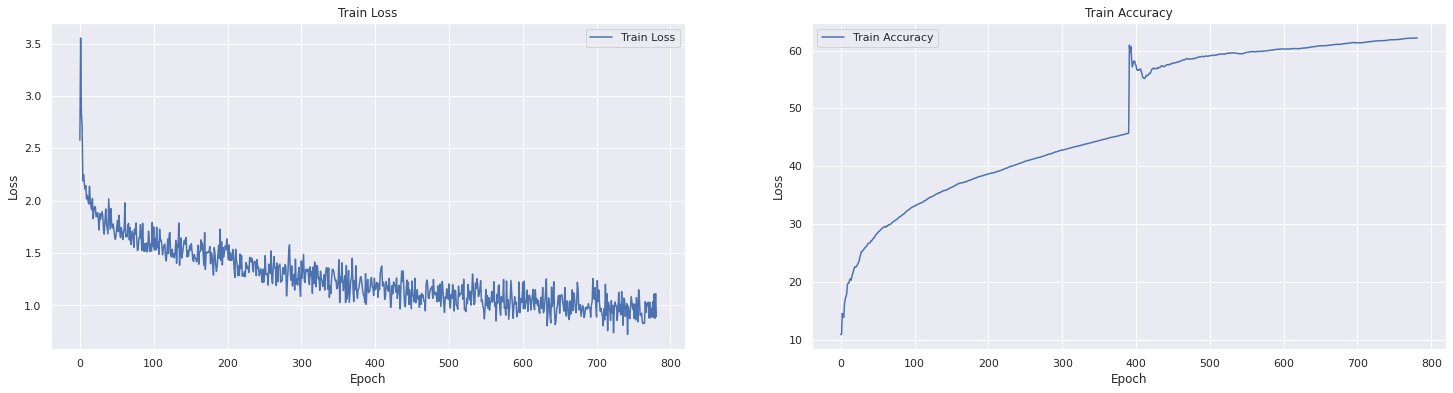

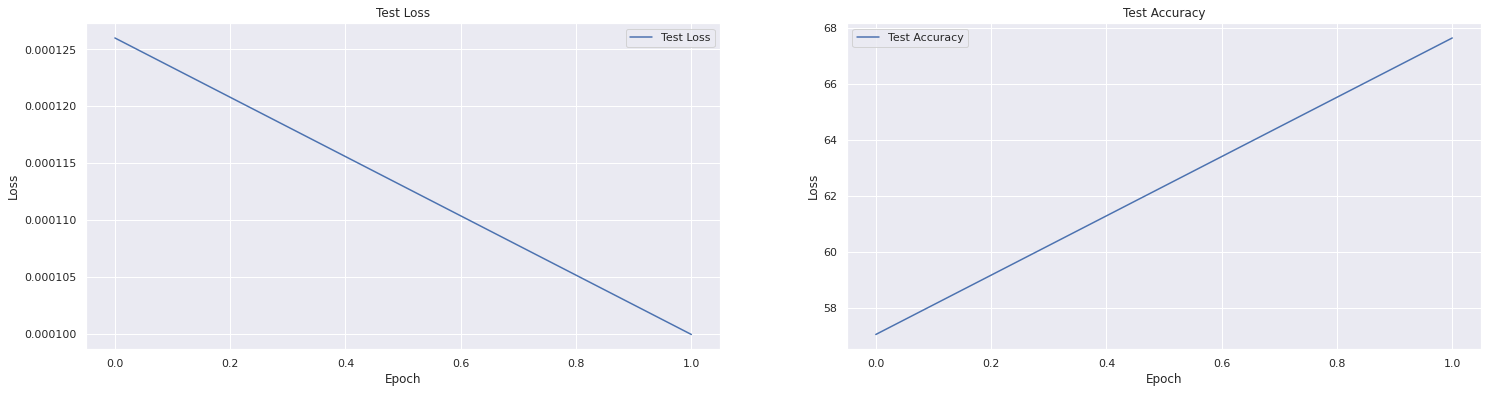

In [20]:
import seaborn as sns

def plot_metrics(train_accuracy, train_losses, test_accuracy, test_losses):
    sns.set(font_scale=1)
    plt.rcParams["figure.figsize"] = (25,6)

    # Plot the learning curve.
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.plot(np.array(train_losses), 'b', label="Train Loss")
    
    # Label the plot.
    ax1.set_title("Train Loss")
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("Loss")
    ax1.legend()
    
    ax2.plot(np.array(train_accuracy), 'b', label="Train Accuracy")
    
    # Label the plot.
    ax2.set_title("Train Accuracy")
    ax2.set_xlabel("Iterations")
    ax2.set_ylabel("Loss")
    ax2.legend()
    
    plt.show()
    
    # Plot the learning curve.
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.plot(np.array(test_losses), 'b', label="Test Loss")
    
    # Label the plot.
    ax1.set_title("Test Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    
    ax2.plot(np.array(test_accuracy), 'b', label="Test Accuracy")
    
    # Label the plot.
    ax2.set_title("Test Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend()
    
    plt.show()

plot_metrics(train_accuracy, train_losses, test_accuracy, test_losses)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

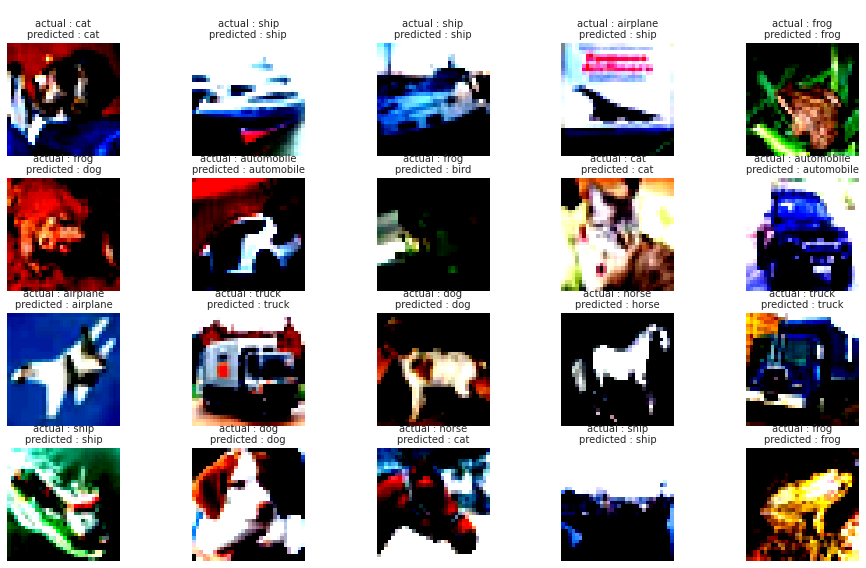

In [33]:
def show_predicted_actual(model, device, dataset_loader, label_names,num_images=10):
	'''
	shows a batch of predicted and actual images (default=10 )
	'''
	images, targets = next(iter(dataset_loader))
	images = images.to(device)
	outputs = model(images)
	_, predicted = torch.max(outputs, 1)

	plt.figure(figsize=(16, 12))
	for i in range(num_images):
		ax = plt.subplot(int(num_images//5)+1, 5, i + 1)
		ax.imshow(images[i].cpu().permute(1, 2, 0))
		ax.set_title(f"\nactual : {label_names[targets[i]]}\npredicted : {label_names[predicted[i]]}", fontsize=10)

		# plt.title("actual:"+label_names[targets[i]])
		plt.axis("off")

show_predicted_actual(model, device, testloader, labels,num_images=20)

In [34]:
def evaluate_classwise_accuracy(model, device, classes, test_loader):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
            	label = labels[i]
            	class_correct[label] += c[i].item()
            	class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
      
evaluate_classwise_accuracy(model, device, labels, testloader)


Accuracy of airplane : 55 %
Accuracy of automobile : 92 %
Accuracy of  bird : 78 %
Accuracy of   cat : 61 %
Accuracy of  deer : 59 %
Accuracy of   dog : 51 %
Accuracy of  frog : 52 %
Accuracy of horse : 64 %
Accuracy of  ship : 90 %
Accuracy of truck : 87 %
